# **Introduction to Tools and Agents**

## **What's Covered?**
1. Understanding the need of Tools
    - The Problem
    - The Solution: AI Agents 
2. Introduction to Tools
    - What is a Tool?
    - Syntax
    - What is a StructuredTool?
    - Building a Multiply StructuredTool
    - Building an Addition StructuredTool
3. Introduction to Agents
    - What is a ReAct Agent?
    - Creating a ReAct Agent
    - Important notes on create_agent()
    - Streaming Agent Output
4. Manual Tool Calling and Looping
    - Step 1 - Initializing a Large Language Model
    - Step 2 - Initializing a Tool
    - Step 3 - Binding the Tool with LLM
    - Step 4 - Tool Calling and Executing the Loop
5. Building an Autonomous AI Agent with create_agent()
    - Step 1 - Init a LLM
    - Step 2 - Init a Tool
    - Step 3 - Init an Agent with create_agent()
    - Step 4 - Execute the Agent
    - Step 5 - Pretty Print
6. Built-in Tools
    - Duck Duck Go Search

## **Understanding the need of Tools**

### **The Problem**
LLMs are powerful but fundamentally limited. Here are 5 major limitations:
1. Stateless i.e. forgets converstaion context
2. Hallucinate i.e. make up facts confidently
3. No real-time data.
4. No actions i.e. can't book flights, or send emails.
5. Poor at precise mathematical calculations.

In [1]:
from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

/Users/kanavbansal/Developer/.env_langchain/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
response = llm.invoke("What is the current time?")

print(response.content)

I don't have real-time capabilities to provide the current time. You can check the time on your device or through a search engine.


In [3]:
response = llm.invoke("What's the weather in NYC right now?")

print(response.content)

I don't have real-time data access to provide current weather information. I recommend checking a reliable weather website or app for the latest updates on the weather in New York City.


In [4]:
response = llm.invoke("Calculate 123456 * 789012")

print(response.content)

The product of 123456 and 789012 is 97,674,432.


### **The Solution: AI Agents**
An AI agent combines LLM reasoning with external tool execution to autonomously solve complex, multi-step problems that require both thinking and acting in the real world.

Think of it like this:
> **Agent = Reasoning and Decision Making (using LLMs) + Action (using Tools)**

The LLM thinks (**reasoning loop**), decides (**which tool/action**), and acts (**calls APIs/tools**), then repeats until the goal is achieved.


**Example execution tree**
```
User: "Should I bring an umbrella to NYC today?"

[LLM]: Thought: Check NYC weather → Action: get_weather(city="NYC")
[Tool]: "NYC: Sunny, 72°F, 0% chance rain"
[LLM]: Thought: No rain → Final Answer: "No umbrella needed"
```

## **Introduction to Tools**

### **What is a Tool?**
Tools are structured functions the LLM can call. 


### **Syntax**
Each tool has:
- Name + Description (LLM decides when to use)
- Input schema (LLM generates structured args)
- Execution logic (calls APIs, databases, etc.)

```python
from langchain_core.tools import tool

@tool(name_or_callable="multiply", description="Multiply two numbers")
def multiply_tool(a: int, b: int) -> int:
    return a * b

multiply_tool.invoke({'a':2, 'b':3})
```

### **What is a StructuredTool?**

StructuredTool is a LangChain v0.1 class for creating tools with structured input schemas using Pydantic models, but in v1.x it's replaced by the simpler @tool decorator.

In LangChain v1.x (current Python docs), you define structured tools directly with the @tool decorator and args_schema parameter. Type hints automatically generate the JSON schema for the LLM, and Pydantic models provide validation.

### **Building a Multiply StructuredTool**

In [5]:
from pydantic import BaseModel, Field

class MathInput(BaseModel):
    a: int = Field(description="The first number")
    b: int = Field(description="The second number")

In [6]:
from langchain_core.tools import tool

@tool(name_or_callable="multiply", description="Multiply two numbers", args_schema=MathInput)
def multiply_tool(a: int, b: int) -> int:
    return a * b

In [7]:
result = multiply_tool.invoke({'a':2, 'b':3})

print(result)
print(multiply_tool.name)
print(multiply_tool.description)
print(multiply_tool.args)

6
multiply
Multiply two numbers
{'a': {'description': 'The first number', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'The second number', 'title': 'B', 'type': 'integer'}}


### **Building an Addition StructuredTool**

In [8]:
from langchain_core.tools import tool

@tool(name_or_callable="addition", description="Add two numbers", args_schema=MathInput)
def add_tool(a: int, b: int) -> int:
    return a + b

In [9]:
result = add_tool.invoke({'a':2, 'b':3})

print(result)
print(add_tool.name)
print(add_tool.description)
print(add_tool.args)

5
addition
Add two numbers
{'a': {'description': 'The first number', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'The second number', 'title': 'B', 'type': 'integer'}}


## **Introduction to Agents**
### **What is a ReAct Agent?**

An AI agent is an intelligent system that receives a high level goal from a user, and autonomously plans, decides and executes a sequence of actions by using external tools, APIs or knowledge sources - all while maintaining context and reasoning over multiple steps.

In short, 
> **Agent = Reasoning and Decision Making (using LLMs) + Action (using Tools)**

Agents combine language models with tools to create systems that can reason about tasks, decide which tools to use, and iteratively work towards solutions.


### **Creating a ReAct Agent**
Let's now create an Agent that can autonomously call the multiply tool or add tool during execution for any user query.

We will use **create_agent()** to build ReAct agents that automatically reason, select tools, and execute actions.

The create_agent() method combines an LLM with tools into a complete agent. Here's how it works:
- create_agent() method expects llm and tools.
- Agent will know what tools are available.
- Via tool's description, it knows what each tool does.
- Via tool's args_schema, it knows what input format to use.
- Agent will execute tools and loop until goal achieved

In [10]:
from langchain.agents import create_agent

agent = create_agent(
    model=llm,
    tools=[multiply_tool, add_tool],
    system_prompt="You are a helpful assistant",
)

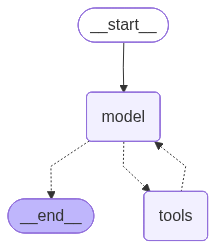

In [11]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [12]:
response = agent.invoke({"messages": "Hi"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [13]:
response = agent.invoke({"messages": "Calculate 123456 * 789012"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Calculate 123456 * 789012
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lsQxpAE7AwQ3BKizjVzTT1F6)
 Call ID: call_lsQxpAE7AwQ3BKizjVzTT1F6
  Args:
    a: 123456
    b: 789012
================================= Tool Message =================================
Name: multiply

97408265472
================================== Ai Message ==================================

The result of \( 123456 \times 789012 \) is \( 97,408,265,472 \).


### **Important notes on create_agent()**

1. create_agent() builds a complete reasoning + execution loop
2. Full autonomous agent
3. Automatic tool calling
4. Automatic loop i.e. multiple tool calling until done

### **Streaming Agent Output**

In [14]:
for token, metadata in agent.stream(
    {"messages": "Calculate 123456 * 789012"},
    stream_mode="messages"    
):
    if token.content:
        print(token.content, end="", flush=True)

97408265472The result of \( 123456 \times 789012 \) is \( 97,408,265,472 \).

## **Manual Tool Calling and Looping**

### **Step 1 - Initializing a Large Language Model**

In [35]:
from langchain_openai import ChatOpenAI

# Setup API Key
f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

response = llm.invoke("What is the current time?")

print(response.content)

I don't have real-time capabilities to provide the current time. You can check the time on your device or through a search engine.


In [36]:
response = llm.invoke("Is Sunita William currently in space?")

print(response.content)

As of my last update in October 2023, I do not have real-time information about current space missions or the status of astronauts. To find out if Sunita Williams is currently in space, I recommend checking the latest updates from NASA or other reliable space news sources.


### **Step 2 - Initializing a Tool**

In [38]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def current_datetime():
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"The current date and time is {current_datetime}"

current_datetime.invoke({})

'The current date and time is 2025-12-17 20:34:23'

### **Step 3 - Binding the Tool with LLM**

- **llm.bind_tools() gives the LLM tool awareness**. 
- LLM can reason and decide to call tool.
- Unlike create_agent(), **it doesnot actually call the tool**.

In [39]:
llm_with_tool = llm.bind_tools([current_datetime])

llm_with_tool

RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x1161f2650>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1161f3360>, root_client=<openai.OpenAI object at 0x1161f2b10>, root_async_client=<openai.AsyncOpenAI object at 0x1161f1cd0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'current_datetime', 'description': 'This function tells the current date and tim

In [40]:
response = llm_with_tool.invoke("Hi")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: Hello! How can I assist you today?
Tool Call: []


In [41]:
response.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [42]:
response = llm_with_tool.invoke("What is the current date?")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: 
Tool Call: [{'name': 'current_datetime', 'args': {}, 'id': 'call_6gaJxdIqeoB0pvrZU5L1hlIH', 'type': 'tool_call'}]


In [43]:
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_6gaJxdIqeoB0pvrZU5L1hlIH)
 Call ID: call_6gaJxdIqeoB0pvrZU5L1hlIH
  Args:


### **Step 4 - Tool Calling and Executing the Loop**

**Important Note:** 
- You may hear the term "function calling". We use this interchangeably with "tool calling".
- With llm.bind_tools(), the LLM doesnot actually run the tool. It just suggest the tool and the input arguments.
- The actual execution should be handled manually.

In [44]:
dict_with_tool_names = {
    "current_datetime": current_datetime,
}

def custom_agent_executor(response):
    if response.tool_calls:
        for tool_calls in response.tool_calls:
            tool_name = tool_calls["name"]
            tool_args = tool_calls["args"]
            tool_func = dict_with_tool_names[tool_name]
            return tool_func.invoke(tool_args)
    else:
        return response.content

In [45]:
custom_agent_executor(llm_with_tool.invoke("Hi"))

'Hello! How can I assist you today?'

In [46]:
custom_agent_executor(llm_with_tool.invoke("What is the time?"))

'The current date and time is 2025-12-17 20:38:46'

## **Building an Autonomous AI Agent with create_agent()**

### **Step 1 - Init a LLM**

In [47]:
from langchain_openai import ChatOpenAI

f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

### **Step 2 - Init a Tool**

In [15]:
from datetime import datetime

def current_datetime() -> str:
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"{current_datetime}"

current_datetime()

'2025-12-08 19:01:30'

In [16]:
import requests

def people_in_space() -> dict:
    """This function returns the number and name of people in space."""
    response = requests.get("http://api.open-notify.org/astros.json")
    return response.json()

people_in_space()

{'people': [{'craft': 'ISS', 'name': 'Oleg Kononenko'},
  {'craft': 'ISS', 'name': 'Nikolai Chub'},
  {'craft': 'ISS', 'name': 'Tracy Caldwell Dyson'},
  {'craft': 'ISS', 'name': 'Matthew Dominick'},
  {'craft': 'ISS', 'name': 'Michael Barratt'},
  {'craft': 'ISS', 'name': 'Jeanette Epps'},
  {'craft': 'ISS', 'name': 'Alexander Grebenkin'},
  {'craft': 'ISS', 'name': 'Butch Wilmore'},
  {'craft': 'ISS', 'name': 'Sunita Williams'},
  {'craft': 'Tiangong', 'name': 'Li Guangsu'},
  {'craft': 'Tiangong', 'name': 'Li Cong'},
  {'craft': 'Tiangong', 'name': 'Ye Guangfu'}],
 'number': 12,
 'message': 'success'}

### **Step 3 - Init an Agent with create_agent()**

Use create_agent() to build ReAct agents that automatically reason, select tools, and execute actions.

The create_agent() method combines an LLM with tools into a complete agent. Here's how it works:
- create_agent() method expects llm and tools.
- Agent will know what tools are available.
- Via tool's description, it knows what each tool does.
- Via tool's args_schema, it knows what input format to use.
- Agent will execute tools and loop until goal achieved

**Important Note:** The LLM doesnot actually run the tool. It just suggest the tool and the input arguments. The actual execution is handled by LangChain.

In [17]:
from langchain.agents import create_agent

agent = create_agent(
    model=llm,
    tools=[current_datetime, people_in_space],
    system_prompt="You are a helpful assistant",
)

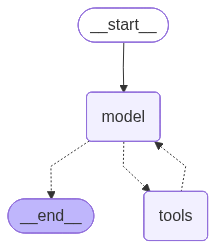

In [18]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

**IMPORTANT:** Note that we are passing in the **llm**, not **llm_with_tools**. That is because **create_agent** will call **.bind_tools** for us under the hood.

### **Step 4 - Execute the Agent**

In [19]:
response = agent.invoke({"messages": "Hi"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [20]:
response = agent.invoke({"messages": "What is the time?"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is the time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_51LKmYAcVloU7jU5yET03Coe)
 Call ID: call_51LKmYAcVloU7jU5yET03Coe
  Args:
================================= Tool Message =================================
Name: current_datetime

2025-12-08 19:01:50
================================== Ai Message ==================================

The current time is 19:01:50 (7:01 PM) on December 8, 2025.


### **Step 5 - Pretty Print**

In [21]:
def printer(input_prompt):
    for s in agent.stream(input_prompt, stream_mode="values"):
        msg = s["messages"][-1]
        if isinstance(msg, tuple):
            print("tuple:", msg)
        else:
            msg.pretty_print()

In [22]:
printer(input_prompt={"messages": "hi"})

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [23]:
printer(input_prompt={"messages": "time?"})

================================ Human Message =================================

time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_TLWY2RYyh9KH5FroxKAtgx4b)
 Call ID: call_TLWY2RYyh9KH5FroxKAtgx4b
  Args:
================================= Tool Message =================================
Name: current_datetime

2025-12-08 19:02:03
================================== Ai Message ==================================

The current date and time is December 8, 2025, at 19:02:03.


In [24]:
printer(input_prompt={"messages": "Can you tell me the names of all the people in space?"})

================================ Human Message =================================

Can you tell me the names of all the people in space?
================================== Ai Message ==================================
Tool Calls:
  people_in_space (call_12h1Tsa9oJlDHxz8G9lwmucQ)
 Call ID: call_12h1Tsa9oJlDHxz8G9lwmucQ
  Args:
================================= Tool Message =================================
Name: people_in_space

{"people": [{"craft": "ISS", "name": "Oleg Kononenko"}, {"craft": "ISS", "name": "Nikolai Chub"}, {"craft": "ISS", "name": "Tracy Caldwell Dyson"}, {"craft": "ISS", "name": "Matthew Dominick"}, {"craft": "ISS", "name": "Michael Barratt"}, {"craft": "ISS", "name": "Jeanette Epps"}, {"craft": "ISS", "name": "Alexander Grebenkin"}, {"craft": "ISS", "name": "Butch Wilmore"}, {"craft": "ISS", "name": "Sunita Williams"}, {"craft": "Tiangong", "name": "Li Guangsu"}, {"craft": "Tiangong", "name": "Li Cong"}, {"craft": "Tiangong", "name": "Ye Guangfu"}], "number": 12, "me

In [25]:
printer(input_prompt={"messages": "Is Sunita William in space?"})

================================ Human Message =================================

Is Sunita William in space?
================================== Ai Message ==================================
Tool Calls:
  people_in_space (call_EKLK9QGEaljtfJTVj1Vy31k9)
 Call ID: call_EKLK9QGEaljtfJTVj1Vy31k9
  Args:
================================= Tool Message =================================
Name: people_in_space

{"people": [{"craft": "ISS", "name": "Oleg Kononenko"}, {"craft": "ISS", "name": "Nikolai Chub"}, {"craft": "ISS", "name": "Tracy Caldwell Dyson"}, {"craft": "ISS", "name": "Matthew Dominick"}, {"craft": "ISS", "name": "Michael Barratt"}, {"craft": "ISS", "name": "Jeanette Epps"}, {"craft": "ISS", "name": "Alexander Grebenkin"}, {"craft": "ISS", "name": "Butch Wilmore"}, {"craft": "ISS", "name": "Sunita Williams"}, {"craft": "Tiangong", "name": "Li Guangsu"}, {"craft": "Tiangong", "name": "Li Cong"}, {"craft": "Tiangong", "name": "Ye Guangfu"}], "number": 12, "message": "success"}
=======

## **Built-in Tools**

List of Buit-in Tools: https://docs.langchain.com/oss/python/integrations/tools

### **Duck Duck Go Search**

In [1]:
# ! pip install ddgs

In [2]:
# ! pip install ddgs
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

print(search_tool.name)
print(search_tool.description)
print(search_tool.args)

duckduckgo_search
A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.
{'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}}


In [3]:
results = search_tool.invoke('messi india tour stadium chaos')

print(results)

Lionel Messi ’s India tour began in chaos as angry fans stormed Kolkata’s Salt Lake Stadium after his brief, unseen appearance. Lionel Messi fans cause chaos as star visits Kolkata stadium on first day of India tour West Bengal's chief minister says she is "deeply disturbed and shocked" and has apologised to Messi and ... The organiser of Lionel Messi's tour of India has been remanded to 14 days in police custody after the footballer's brief appearance at the Salt Lake Stadium in Kolkata ended in chaos . Footage ... Hours after the Kolkata stop of Lionel Messi's India tour descended into mayhem as angry fans ripped up seats and invaded the field, police in the eastern Indian city stopped the organiser of the ... Lionel Messi's tour of India kicked off chaotically on Saturday as fans threw objects, ripped up seats and invaded the pitch at Kolkata's Salt Lake Stadium after the Argentine soccer great made ...
